### https://docs.google.com/presentation/d/1s1Xpz4m4PJBzxJFdDGiXTNEt2731eTHiYkQI7ihOhfE/edit#slide=id.p

In [69]:
import torch
import torch.nn as nn

In [70]:
# input(저장) - 배치 정규화 - ReLu - 합성곱 3*3 - 배치 정규화 - skip connection - ReLu => 기본 블록

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes = 3):
        super(BasicBlock, self).__init__()
        
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_sizes, padding = 1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_sizes, padding = 1)
        
        # skip connection 채널을 맞춰주기 위해서 정보를 저장하기 위해서 쓰는거라 필터는 그대로 1로 통과시켜준다. feature map의 갯수만 맞춰주는 거야
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = out_channels)
        self.bn2 = nn.BatchNorm2d(num_features = out_channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x_ = x
        
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)
        
        # skip connection
        # 채널수를 맞춰준다. : 아웃풋으로 나온 채널 수를 맞춤
        x_ = self.downsample(x_)
        x += x_
        x = self.relu(x)
        
        return x

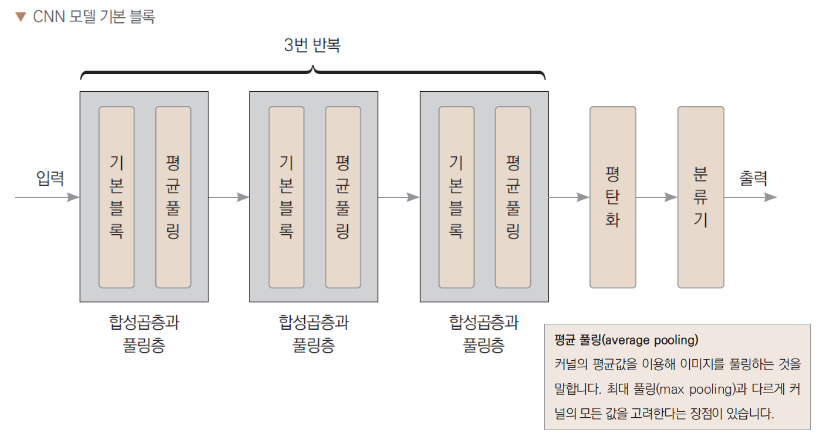

In [78]:
class ReseNet(nn.Module):
    # num_classes 는 지금은 cifar 출력이 마지막에 10으로 나오기때문에 다른 데이터에 적용할때 쉽게 하기 위해서
    def __init__(self, num_classes = 10):
        super(ReseNet, self).__init__()
        
        # R G B니까 처음 in_channel은 3채널로 들어간다.
        self.b1 = BasicBlock(in_channels=3, out_channels=64)
        self.b2 = BasicBlock(in_channels=64, out_channels=128)
        self.b3 = BasicBlock(in_channels=128, out_channels=256)
        
        # 이렇게 들어가면 이미지가 반절로 줄겠죠
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
        # 평평하게 핀다.
        
        # 분류기 
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        
        x = self.b2(x)
        x = self.pool(x)
        
        x = self.b3(x)
        x = self.pool(x)
        
        # 평탄화
        x = torch.flatten(x, start_dim = 1)
        
        # 분류기
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [80]:
model = ReseNet(10)
model.to(device)

ReseNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [81]:
from torchsummary import summary

summary(model, (3, 32, 32))
# 모델에서 분류기를 빼고 이 코드를 실행하면 마지막  AvgPool2d-27            [-1, 256, 4, 4]  에서 256*4*4 를 하면 4096 in_feature값이 나온다.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]             256
              ReLU-7           [-1, 64, 32, 32]               0
        BasicBlock-8           [-1, 64, 32, 32]               0
         AvgPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1, 128,

### 데이터 전처리

In [22]:
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

#### 데이터 정규화

In [82]:
transforms = Compose([
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247,0.243,0.261))
])

In [83]:
train_data = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transforms
)

test_data = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transforms
)

Files already downloaded and verified
Files already downloaded and verified


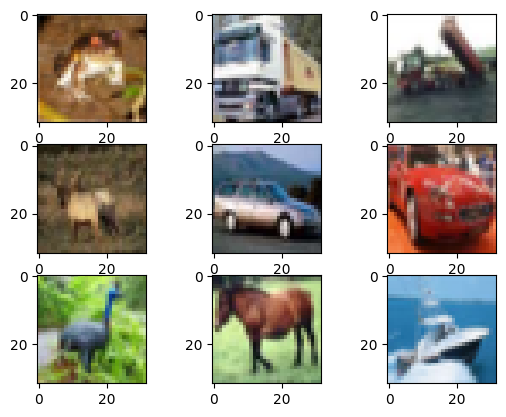

In [37]:
for temp in range(9):
    plt.subplot(3,3,temp+1)
    plt.imshow(train_data.data[temp])
plt.show()

In [84]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [66]:
data,label = next(iter(train_loader))
print(data.shape)
print(label.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
device

'cuda'

#### 모델 불러오기

In [87]:
model = ReseNet(10)
model.to(device)

ReseNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [65]:
from torchsummary import summary

summary(model, (3, 32, 32))
# 모델에서 분류기를 빼고 이 코드를 실행하면 마지막  AvgPool2d-27            [-1, 256, 4, 4]  에서 256*4*4 를 하면 4096 in_feature값이 나온다.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]             256
              ReLU-7           [-1, 64, 32, 32]               0
        BasicBlock-8           [-1, 64, 32, 32]               0
         AvgPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1, 128,

## 모델 학습

In [88]:
import tqdm
lr = 1e-4
optim = Adam(model.parameters(), lr = lr)

# 학습이 얼마나 걸리는 지 확인하기위해 tqdm 사용
for epoch in range(30):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
        
    print(f'epoch : {epoch+1} loss : {loss.item()}')
    
torch.save(model.state_dict(), 'resnet.pth')

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.62it/s]


epoch : 1 loss : 1.0913444757461548


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:43<00:00, 35.63it/s]


epoch : 2 loss : 0.9367656111717224


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 33.22it/s]


epoch : 3 loss : 0.430703341960907


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.31it/s]


epoch : 4 loss : 0.6426915526390076


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.31it/s]


epoch : 5 loss : 0.7039581537246704


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.26it/s]


epoch : 6 loss : 0.6253506541252136


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.36it/s]


epoch : 7 loss : 0.5618157386779785


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.83it/s]


epoch : 8 loss : 0.2153637558221817


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.37it/s]


epoch : 9 loss : 0.4370894432067871


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.40it/s]


epoch : 10 loss : 0.24337045848369598


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.97it/s]


epoch : 11 loss : 0.29680368304252625


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.85it/s]


epoch : 12 loss : 0.2785570025444031


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:43<00:00, 35.71it/s]


epoch : 13 loss : 0.12038463354110718


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.58it/s]


epoch : 14 loss : 0.36040472984313965


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.80it/s]


epoch : 15 loss : 0.04895126074552536


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.22it/s]


epoch : 16 loss : 0.17764462530612946


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.87it/s]


epoch : 17 loss : 0.1053123027086258


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.89it/s]


epoch : 18 loss : 0.12754115462303162


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.29it/s]


epoch : 19 loss : 0.5551444888114929


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:46<00:00, 33.32it/s]


epoch : 20 loss : 0.16646604239940643


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.40it/s]


epoch : 21 loss : 0.0401194803416729


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.85it/s]


epoch : 22 loss : 0.5048169493675232


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.20it/s]


epoch : 23 loss : 0.08408945798873901


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.86it/s]


epoch : 24 loss : 0.009934586472809315


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:48<00:00, 32.09it/s]


epoch : 25 loss : 0.008775400929152966


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:45<00:00, 34.60it/s]


epoch : 26 loss : 0.11101700365543365


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 35.09it/s]


epoch : 27 loss : 0.05968642979860306


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 34.78it/s]


epoch : 28 loss : 0.18794052302837372


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 32.77it/s]


epoch : 29 loss : 0.03962427377700806


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:48<00:00, 32.11it/s]


epoch : 30 loss : 0.060552094131708145


In [89]:
num_corr =  0

model.eval()
with torch.no_grad():
    for data,label in test_loader:
        pred = model(data.to(device))
        preds = pred.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
num_corr/len(test_data)

0.8844